***CORD-19 Literature Clustering, Topic Modeling and Semantic Bases Search using Machine Learning, NLP and TigerGraph***

* Given the large number of literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. 
* The evaluation and filtering phase is therefore time consuming and hardly expressible to the intended audience. **The proposed method applies natural language processing (NLP) on article meta data and a k-means clustering algorithm to automatically convert large article corpora into a distribution of focal topics.** This allows efficient filtering as well as objectifying the process through the discussion of the clustering results. 
* In order, to **find meaning in the clusters, topic modeling will be performed to find the keywords of each cluster**.
* By using Bokeh, the plot will be interactive. Hovering over points on the plot will give basic information like title and abstract. This tool was created to help make it easier for trained professionals to sift through many, many publications related to the virus, and find their own determinations.
* With over 57,000 scholarly articles on the coronavirus family, it is extremely difficult for the medical researchers to go through this tremendous amount of research papers, hence very difficult to get useful insights about the new Covid-19 pandemic. **The main goal is to implement a semantic-based search rather a keyword-based search.**
* Instead of comparing occurences and counts, we will use gensim's word2vec in order to generate word embedding using the abstract texts as our corpus. For each document, we calculate the centroid of its abstract and for each query word, we map it to a vector then calculate the word centroid similarity for the query and each document's abstract. The top ranked papers are then selected and output.

**Pipeline:**
* **Literature Clustering:** Import all the required libraries -> Read the dataset -> Clean the data -> Transforms the text into a usable vector -> Simplify data -> Find numbers of clusters to make -> Cluster unlabeled data -> Visualise the structure of high dimensional data in 2 dimensions
* **LDA:** Create a dictionary from the data -> Convert dictionary to bag-of-words corpus -> Pick no of topics in the data -> Define a lda model -> Check the proportion of topics -> Visualize the result
* **Semantic Search:** Tokenize the data -> Define a word2vec model -> Generate word embedding -> Calculate the centroid for the data in each document and query -> Map to vector -> Calculate the word centroid similarity for the query and data from document -> Visualize the top result

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)
parser = en_core_web_sm.load(disable=["tagger", "ner"])
parser.max_length = 7000000
import string
punctuations = string.punctuation
from tqdm import tqdm
import importlib
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, LdaMulticore
import pyLDAvis.gensim
from gensim.corpora import Dictionary

from bokeh.layouts import row
from bokeh.models import CustomJS, HoverTool
from bokeh.io import show, output_notebook
from bokeh.plotting import ColumnDataSource, figure, show
from bokeh.palettes import Paired10
from bokeh.transform import linear_cmap

#Install pyTigerGraph package in the google colab
!pip install -U pyTigerGraph
#Import and implement these packages that we install previously
import pyTigerGraph as tg

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Reading the dataset
data = pd.read_csv('../input/cord-19-eda-parse-json-and-generate-clean-csv/biorxiv_clean.csv')
data.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,bbf09194127619f57b3ddf5daf684593a5831367,The Effectiveness of Targeted Quarantine for M...,"Alastair Jamieson-Lane, Eric Cytrnbaum",Alastair Jamieson-Lane (Carl von Ossietzky Uni...,Abstract\n\nWe model the extent to which age t...,"Introduction\n\nCOVID-19, initially observed/d...",Impact of non-pharmaceutical interventions (NP...,"[{'first': 'Alastair', 'middle': [], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Impact ..."
1,2a21fdd15e07c89c88e8c2f6c6ab5692568876ec,Evaluation of Group Testing for SARS-CoV-2 RNA,"Nasa Sinnott-Armstrong, Daniel L Klein, Brenda...","Nasa Sinnott-Armstrong, Daniel L Klein, Brenda...",Abstract\n\nDuring the current COVID-19 pandem...,Introduction\n\nGroup testing was first descri...,"In one Italian town, we showed mass testing co...","[{'first': 'Nasa', 'middle': [], 'last': 'Sinn...","{'BIBREF0': {'ref_id': 'b0', 'title': 'In one ..."
2,e686d1ce1540026ecb100c09f99ed091c139b92c,Why estimating population-based case fatality ...,"Lucas Böttcher, Mingtao Xia, Tom Chou","Lucas Böttcher, Mingtao Xia (UCLA, 90095-1555,...",Abstract\n\nDifferent ways of calculating mort...,\n\nDifferent ways of calculating mortality ra...,"COVID-19 statistics, , , None; The Lancet, Z X...","[{'first': 'Lucas', 'middle': [], 'last': 'Böt...","{'BIBREF2': {'ref_id': 'b2', 'title': 'COVID-1..."
3,c6039f8933305c9f44a44c81a15b321b6c2848dc,Far-UVC light: A new tool to control the sprea...,"David Welch, Manuela Buonanno, Veljko Grilj, I...",David Welch (Columbia University Medical Cente...,Abstract\n\nAirborne-mediated microbial diseas...,3\n\nAirborne-mediated microbial diseases repr...,"Global, regional, and national life expectancy...","[{'first': 'David', 'middle': [], 'last': 'Wel...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Global,..."
4,073d74442e2655d79b0b3f764a627ec667ad422c,Quantifying SARS-CoV-2 transmission suggests e...,"Luca Ferretti, Chris Wymant, Michelle Kendall,...","Luca Ferretti (University of Oxford, Oxford, U...",Abstract\n\nThe newly emergent human virus SAR...,IV.\n\nEnvironmental transmission: transmissio...,"Early Transmission Dynamics in Wuhan, China, o...","[{'first': 'Luca', 'middle': [], 'last': 'Ferr...","{'BIBREF2': {'ref_id': 'b2', 'title': 'Early T..."


***Data Preprocessing***

In [ ]:
data = data[data["abstract"]==data["abstract"]][['abstract','title']]
data = pd.DataFrame({'abstract':data['abstract'],'title':data['title']})
data.head()

,abstract,title
0,Abstract\n\nWe model the extent to which age t...,The Effectiveness of Targeted Quarantine for M...
1,Abstract\n\nDuring the current COVID-19 pandem...,Evaluation of Group Testing for SARS-CoV-2 RNA
2,Abstract\n\nDifferent ways of calculating mort...,Why estimating population-based case fatality ...
3,Abstract\n\nAirborne-mediated microbial diseas...,Far-UVC light: A new tool to control the sprea...
4,Abstract\n\nThe newly emergent human virus SAR...,Quantifying SARS-CoV-2 transmission suggests e...


In [ ]:
def clean_data(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations and len(word)>3 ]
    mytokens = ' '.join([i for i in mytokens])
    return mytokens

tqdm.pandas()
data['abstract'] = data['abstract'].progress_apply(lambda text: clean_data(text))
data.head()

100%|██████████| 1410/1410 [00:57<00:00, 24.55it/s]


,abstract,title
0,abstract model extent targeted quarantine redu...,The Effectiveness of Targeted Quarantine for M...
1,abstract current covid-19 pandemic testing ext...,Evaluation of Group Testing for SARS-CoV-2 RNA
2,abstract different ways calculating mortality ...,Why estimating population-based case fatality ...
3,abstract airborne mediated microbial diseases ...,Far-UVC light: A new tool to control the sprea...
4,abstract newly emergent human virus sars cov-2...,Quantifying SARS-CoV-2 transmission suggests e...


In [ ]:
#Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector.
vectorizer = TfidfVectorizer(max_features=24)
#It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF).
X = vectorizer.fit_transform(data['abstract'].values)

***Literature Clustering***

In [ ]:
#PCA is often used to simplify data, reduce noise, and find unmeasured “latent variables
pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(X.toarray())

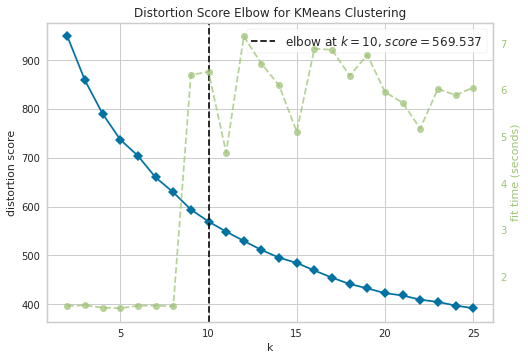

In [ ]:
#Elbow method to find numbers of clusters to make
elbow = KElbowVisualizer(KMeans(), k=25)
elbow.fit(X_reduced)
elbow.show();

In [ ]:
#k-means is a technique for data clustering that may be used for unsupervised machine learning.
k=10
#It is capable of classifying unlabeled data into a predetermined number of clusters based on similarities (k).
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
data['label'] = y_pred
y_pred

array([8, 9, 8, ..., 1, 7, 2], dtype=int32)

In [ ]:
#TSNE widely used in bioinformatics and more generally in data science to visualise the structure of high dimensional data in 2 or 3 dimensions.
tsne = TSNE(verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1410 samples in 0.000s...
[t-SNE] Computed neighbors for 1410 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1410
[t-SNE] Computed conditional probabilities for sample 1410 / 1410
[t-SNE] Mean sigma: 0.334965
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.957382
[t-SNE] KL divergence after 1000 iterations: 1.025416


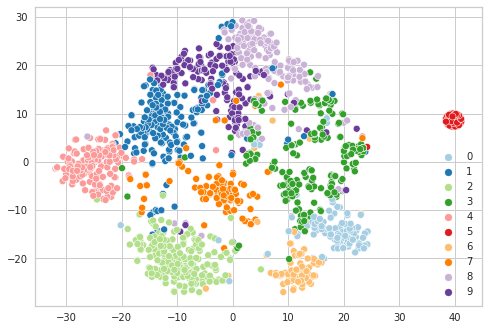

In [ ]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, palette="Paired");

In [ ]:
#Show on Notebook
output_notebook()
#Traget Label
y_labels = y_pred
#Data Source
source = ColumnDataSource(data=dict(
    x = X_embedded[:,0], 
    y = X_embedded[:,1],
    desc = y_labels, 
    titles = data['title'],
    abstract = data['abstract'],
    labels = ["C-" + str(x) for x in y_labels],
    ))

#Hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Abstract", "@abstract{safe}")
],
point_policy="follow_mouse")

mapper = linear_cmap(field_name='desc', 
                     palette=Paired10, low=min(y_labels) ,high=max(y_labels))

plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.1,
          line_width=1.1,
          line_color="black",
          legend_label='labels')

layout = row(plot)
show(layout)

Loading BokehJS ...

***Explore the clusters with Latent Dirichlet Allocation(LDA) Model***

In [ ]:
dictionary = []
corpus = []

for item in range(10):
    docs = [d.split() for d in data[data.label==item]['abstract']]
    dictionary.append(Dictionary(docs))
    corpus.append([dictionary[item].doc2bow(doc) for doc in docs])

In [ ]:
#Latent Dirichlet Allocation (LDA) is a popular topic modeling technique to extract topics from a given corpus.
lda_model = []

for item in range(10):
    lda_model.append(LdaMulticore(corpus=corpus[item], num_topics=5, id2word=dictionary[item], passes=20, workers=2))

In [ ]:
for i in range(5):
    print('\nTopic {}'.format(str(i)))
    for term, frequency in lda_model[1].show_topic(i, topn=10):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))


Topic 0
covid-19             0.030
abstract             0.009
public               0.006
coronavirus          0.005
health               0.005
disease              0.005
cases                0.005
study                0.005
number               0.005
data                 0.005

Topic 1
covid-19             0.027
abstract             0.010
china                0.007
spread               0.007
outbreak             0.007
hcws                 0.006
countries            0.006
cases                0.005
risk                 0.004
wuhan                0.004

Topic 2
covid-19             0.012
based                0.009
learning             0.008
students             0.006
medical              0.006
outbreak             0.006
study                0.006
disease              0.006
pandemic             0.005
model                0.005

Topic 3
covid-19             0.025
patients             0.007
study                0.007
clinical             0.007
abstract             0.007
pneumonia          

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model[1], corpus[1], dictionary[1])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.068862  0.039494       1        1  34.623029
0     -0.040225 -0.024347       2        1  27.038949
1     -0.059532  0.033693       3        1  18.362133
3      0.040185 -0.113530       4        1  15.113866
2      0.128434  0.064690       5        1   4.862023, topic_info=            Term       Freq      Total Category  logprob  loglift
19         based  65.000000  65.000000  Default  30.0000  30.0000
306     learning  26.000000  26.000000  Default  29.0000  29.0000
570         hcws  23.000000  23.000000  Default  28.0000  28.0000
62      outbreak  76.000000  76.000000  Default  27.0000  27.0000
328        study  86.000000  86.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
685        virus   3.060262  47.232472   Topic5  -5.8190   0.2871
349     clinical   3.291546  74.928315   Topic5  -5.7462  -0.1015
512         sars   3.030235  59.951171   Topic5  -5.8289   0.0388
29   coronavirus   3.033012  80.287111   Topic5  -5.8280  -0.2523
441        cov-2   2.766159  40.655463   Topic5  -5.9201   0.3360

[380 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         1  0.257027   2019
1         2  0.316341   2019
1         3  0.138399   2019
1         4  0.257027   2019
1         5  0.019771   2019
...     ...       ...    ...
974       4  0.532961  women
74        1  0.364090  wuhan
74        2  0.107085  wuhan
74        3  0.364090  wuhan
74        4  0.149920  wuhan

[715 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])

***Top-N most similar words with Word2Vec Model***

In [ ]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
text_vectorized = vectorizer.fit_transform(data['abstract'])

In [ ]:
sent = [ text.split() for text in data['abstract'] ]
phrases = Phrases(sent, min_count=30) 
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
#The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text.
w2v_model = Word2Vec(sentences=sentences,alpha=0.01,negative=15,min_count=6,vector_size=50)
#Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence.
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)
w2v_model.init_sims(replace=True)

In [ ]:
def create_graph(name,temp):
    conn = tg.TigerGraphConnection(host="<link>", username="<username>", password="<password>", useCert=True)
    print(conn.gsql(
    '''CREATE VERTEX Source_Data (PRIMARY_ID source_data STRING) WITH primary_id_as_attribute="true"
    CREATE VERTEX Target_Data (PRIMARY_ID target_data STRING) WITH primary_id_as_attribute="true"
    CREATE UNDIRECTED EDGE Similarity (FROM Source_Data, TO Target_Data)
    ''', options=[]))
    print(conn.gsql('''CREATE GRAPH lockdown(Source_Data, Target_Data, Similarity)''', options=[]))
    conn.graphname = name
    conn.apiToken = conn.getToken(conn.createSecret())
    conn.upsertVertex('Source_Data',name,name)
    for item in temp:
        conn.upsertVertex('Target_Data',item,item)
        conn.upsertEdge('Source_Data',name,'Similarity','Target_Data',item)

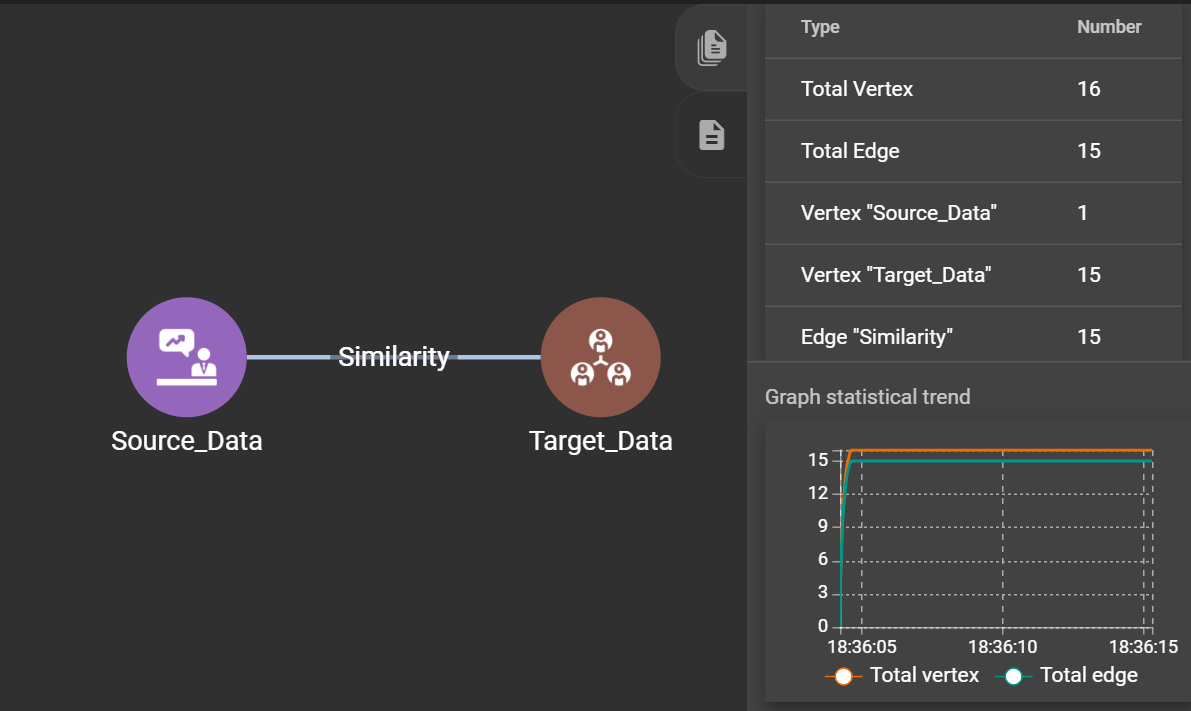

Fig: Graph Schema

In [ ]:
temp = w2v_model.wv.most_similar(positive=["lockdown"],topn=15)
temp = [item[0] for item in temp]
print(temp)
create_graph('lockdown',temp)

['imposed', 'restrictions', 'measures', 'travel', 'control_measures', 'social_distancing', 'strict', 'government', 'quarantine', 'implementation', 'scenario', 'taken', 'interventions', 'policies', 'self']
Successfully created vertex types: [Source_Data].
Successfully created vertex types: [Target_Data].
Successfully created edge types: [Similarity].
The graph lockdown is created.


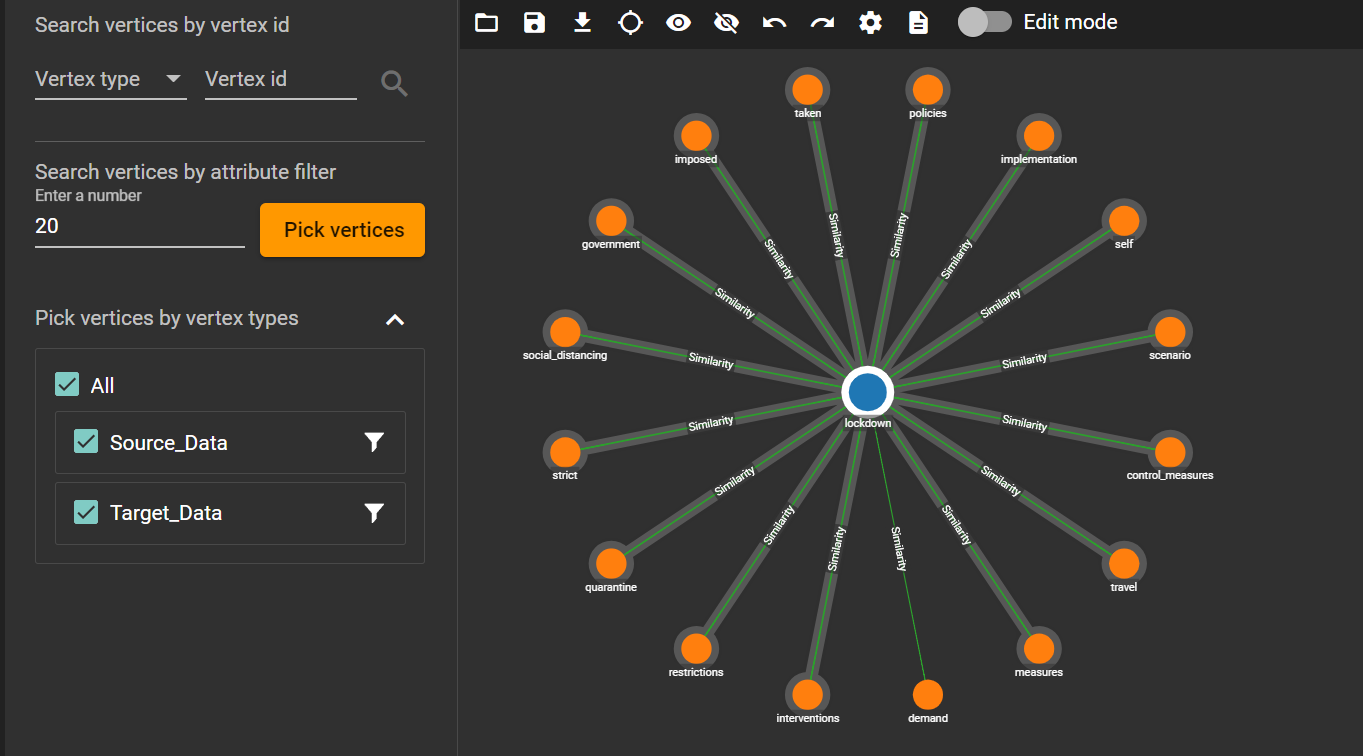

In [ ]:
def create_graph1(temp):
    conn = tg.TigerGraphConnection(host="<link>", username="<username>", password="<password>", useCert=True)
    print(conn.gsql(
    '''CREATE VERTEX Source_Data1 (PRIMARY_ID source_data STRING) WITH primary_id_as_attribute="true"
    CREATE VERTEX Target_Data1 (PRIMARY_ID target_data STRING) WITH primary_id_as_attribute="true"
    CREATE UNDIRECTED EDGE Word_Similarity (FROM Source_Data1, TO Target_Data1)
    ''', options=[]))
    print(conn.gsql('''CREATE GRAPH Drug_Discovery(Source_Data1, Target_Data1, Word_Similarity)''', options=[]))
    conn.graphname = 'Drug_Discovery'
    conn.apiToken = conn.getToken(conn.createSecret())
    conn.upsertVertex('Source_Data','Drug','Drug')
    for item in temp:
        conn.upsertVertex('Target_Data1',item,item)
        conn.upsertEdge('Source_Data1','Drug','Word_Similarity','Target_Data1',item)

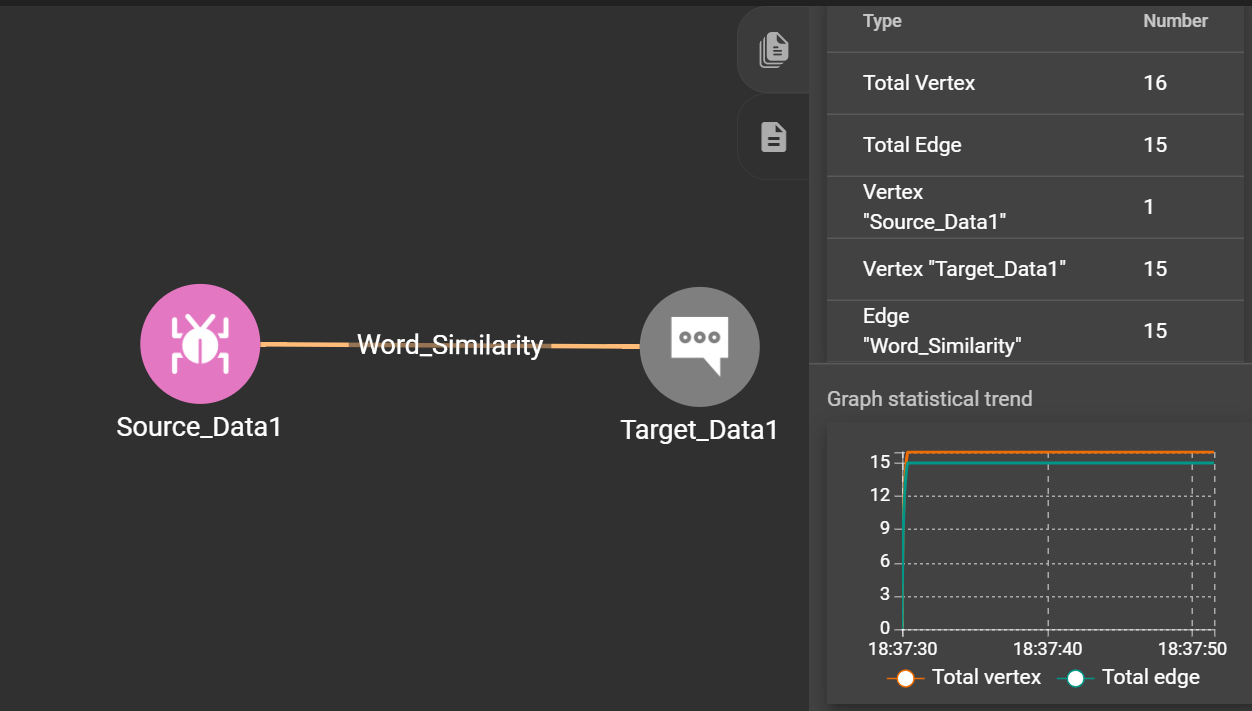

Fig: Graph Schema

In [ ]:
temp = w2v_model.wv.most_similar(positive=["drugs"],topn=15)
temp = [item[0] for item in temp]
print(temp)
create_graph1(temp)

['approved', 'drug', 'therapeutics', 'antiviral', 'therapeutic', 'therapies', 'antivirals', 'anti', 'targets', 'development', 'vaccines', 'spectrum', 'promising', 'candidates', 'compounds']
Successfully created vertex types: [Source_Data1].
Successfully created vertex types: [Target_Data1].
Successfully created edge types: [Word_Similarity].
The graph Drug_Discovery is created.


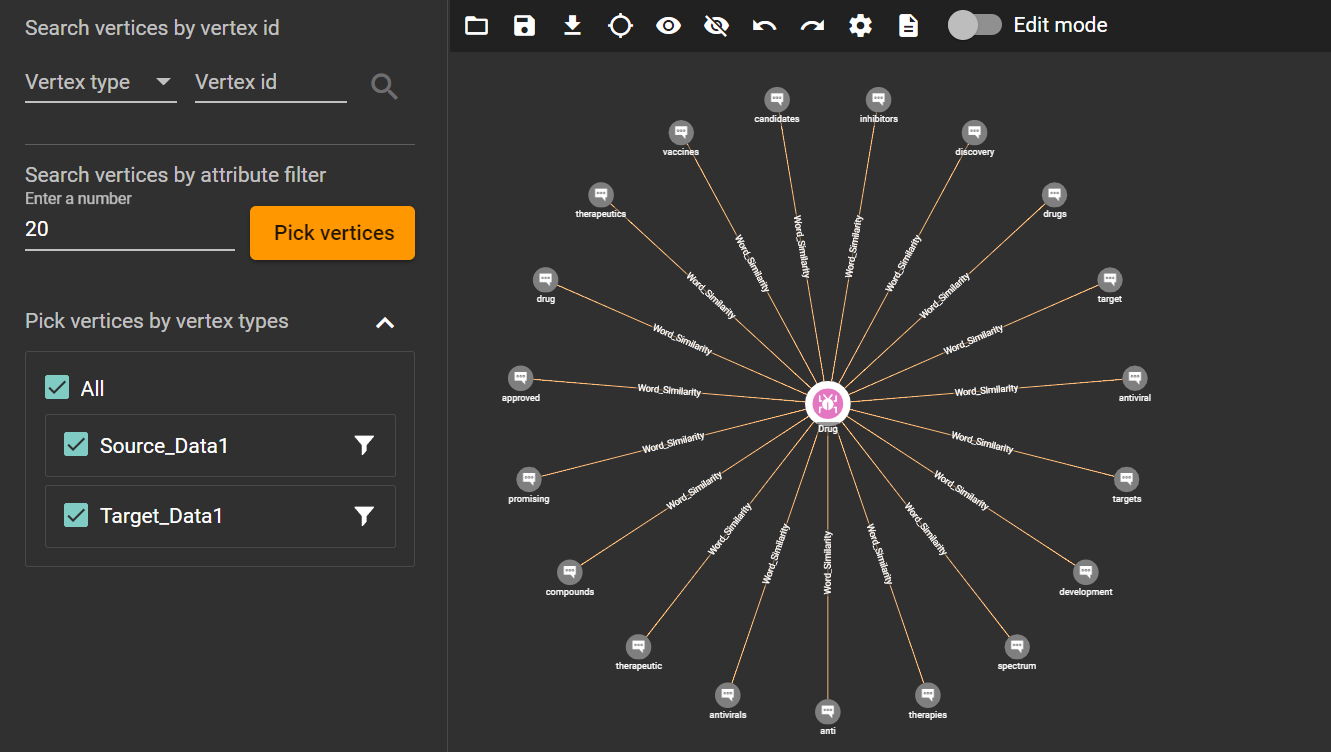

***Semantic-based Search using Word Embedding***

In [ ]:
data['centroid'] = [[0.0]*50]*data.shape[0]
for idx, row in data.iterrows():
    
    words = row['abstract'].split(' ')
    centroid = np.array([0.0]*50)
    for word in words:
        try:
            vec = w2v_model.wv[word]
        except:
            continue
        centroid = np.add(centroid,vec)
        
    data.at[idx,'centroid'] = centroid.tolist()
data.head()

,abstract,title,label,centroid
0,abstract model extent targeted quarantine redu...,The Effectiveness of Targeted Quarantine for M...,8,"[-1.5495523111894727, -3.934292122721672, 4.37..."
1,abstract current covid-19 pandemic testing ext...,Evaluation of Group Testing for SARS-CoV-2 RNA,9,"[0.09740376198897138, -7.556992580881342, -0.1..."
2,abstract different ways calculating mortality ...,Why estimating population-based case fatality ...,8,"[-4.421408356633037, -2.2507512839511037, 7.19..."
3,abstract airborne mediated microbial diseases ...,Far-UVC light: A new tool to control the sprea...,3,"[1.7586849685758352, -4.001182045787573, -2.93..."
4,abstract newly emergent human virus sars cov-2...,Quantifying SARS-CoV-2 transmission suggests e...,8,"[-1.2315361242508516, -3.579214697703719, 5.74..."


In [ ]:
#In data analysis, cosine similarity is a measure of similarity between two sequences of numbers.
def rank_doc(model,data,query,num):
    #Rank the documents from most similar to least similar
    vec = []
    cosine_list = []
    q = query.split(' ')
    for item in q:
        try:vec.append(model.wv[item])
        except:continue
        
    for idx, row in data.iterrows():
        total_sim = 0.0
        for v in vec:
            #Cosine similarity is defined as the cosine of the angle between them, that is, the dot product of the vectors divided by the product of their lengths.
            cos_sim = np.dot(v, row['centroid']) / (np.linalg.norm(v)*np.linalg.norm(row['centroid']))
            total_sim += cos_sim
            
        cosine_list.append((row['title'], total_sim))
        
    cosine_list.sort(key=lambda x:x[1], reverse=True)
    
    papers_list = []
    for item in cosine_list[:num]:
        papers_list.append((item[0], item[1]))
    return papers_list

In [ ]:
query = 'drug discovery'
rank_doc(w2v_model,data,query,10)

[('Identification of antiviral drug candidates against SARS-CoV-2 from FDA-approved drugs',
  1.626290672308695),
 ('Multimerization of HIV-1 integrase hinges on conserved SH3-docking platforms',
  1.620048471607723),
 ('Structure of M pro from COVID-19 virus and discovery of its inhibitors',
  1.6182075287440305),
 ('The target landscape of N4-hydroxycytidine based on its chemical neighborhood',
  1.6174791069581427),
 ('Recapitulation of SARS-CoV-2 Infection and Cholangiocyte Damage with Human Liver Organoids 2 3',
  1.589996135454611),
 ('Nucleotide Analogues as Inhibitors of SARS-CoV-2 Polymerase',
  1.582507986003622),
 ('Designing Effective small interfering RNA for Post-Transcriptional Silencing of Human GREM1: A Comprehensive Bioinformatics Approach',
  1.5795804523294854),
 ('Structure-Based Design, Synthesis and Biological Evaluation of Peptidomimetic Aldehydes as a Novel Series of Antiviral Drug Candidates Targeting the SARS-CoV-2 Main Protease',
  1.5699504478973756),
 ('Id

In [ ]:
query = 'lockdown'
rank_doc(w2v_model,data,query,10)

[('Estimating the Efficacy of Quarantine and Traffic Blockage for the Epidemic Caused by 2019-nCoV (COVID-19)：A Simulation Analysis',
  0.9065071924853434),
 ('Mathematical modeling of COVID-19 transmission and mitigation strategies in the population of Ontario, Canada',
  0.8976637600437712),
 ('The Effectiveness of Social Distancing in Mitigating COVID-19 Spread: a modelling analysis',
  0.8902862561236854),
 ('Impact of self-imposed prevention measures and short-term government intervention on mitigating and delaying a COVID-19 epidemic',
  0.8888196225838138),
 ('Social distancing to slow the U.S. COVID-19 epidemic: interrupted time-series analysis',
  0.8820370183197291),
 (nan, 0.8819653481822604),
 (nan, 0.8815099898130884),
 ('Title: COVID-19 Progression Timeline and Effectiveness of Response-to-Spread Interventions across the United States',
  0.8789327495879519),
 ('Feasibility of Controlling COVID-19 Outbreaks in the UK by Rolling Interventions',
  0.8775454556736517),
 ('Th